# Sun Access Example


## 0. Initialization

### 0.1. Importing libraries and setting global variables

In [235]:
import esm
import os
import trimesh as tm 
import ladybug as lb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from honeybee_plus.radiance.recipe.solaraccess.gridbased import SolarAccessGridBased
from honeybee_plus.radiance.analysisgrid import AnalysisGrid

cwd = os.getcwd()
src = os.path.dirname(cwd)

### 0.2. Importing geometries and assigning materials

In [2]:
# loading the wall mesh
wal_filepath = os.path.join(src, "data", "test_room_walls_02.obj")
wal_mesh = tm.load(wal_filepath)
# converting wall mesh to HB Surfaces
wal_hb_surf = esm.mesh_to_hbsurface(wal_mesh.faces, wal_mesh.vertices, 0, "wall", esm.material_plastic)

# loading the window mesh
fen_filepath = os.path.join(src, "data", "test_room_fens_02.obj")
fen_mesh = tm.load(fen_filepath)
# loading converting window mesh to HB Surfaces
fen_hb_surf = esm.mesh_to_hbsurface(fen_mesh.faces, fen_mesh.vertices, 5, "window", esm.material_glass)

# combining surface lists
hb_surfaces = wal_hb_surf + fen_hb_surf

face lines are weird: 1 6 3 4 5 2


### 0.3. Prepare Analysis Information

In [3]:
# generate grid of test points
test_pts = [(1, 1, 1),(6, 1, 1),(1, 6, 1),(1, 1, 6)]
test_vec = [(0, 0, 1),(0, 0, 1),(0, 0, 1),(0, 0, 1)]
analysis_grid = AnalysisGrid.from_points_and_vectors(test_pts, test_vec, 'test_grid')


# initiate sunpath
sp = lb.sunpath.Sunpath(longitude=4.3571, latitude=52.0116)

# define sun hours : A list of hours of the year for each sun vector
# there are 8760 hours in a year, so the following integers refer to specific hours throughout the year
hoys = []
sun_vectors = []
for i in range(8760):
    # compute the sun object
    sun = sp.calculate_sun_from_hoy(i)
    # extract the sun vector
    sun_vector = sun.sun_vector.to_array()
    # apparantly, if the Z component of sun vector is positive, it is under the horizon 
    if sun_vector[2] < 0.0:
        hoys.append(i)
        sun_vectors.append(sun_vector)

## 1. Simulation

### 1.1. Create Recipe

In [4]:
# put the recipe together
rp = SolarAccessGridBased(sun_vectors, hoys, [analysis_grid], hb_objects=hb_surfaces)

Found 82 opaque surfaces.
Found 1 fenestration surfaces.
Found 0 window-groups.


### 1.2. Create Batch Files

In [5]:
# write simulation to folder
batch_file = rp.write(
    target_folder='.', project_name='sun_acc_cleaned')

Writing recipe contents to: ./sun_acc_cleaned/solaraccess


### 1.3. Run the simulation

In [6]:
# run the simulation
rp.run(batch_file, debug=False)

True

## 2. Results

In [7]:
def parse_results(rp, aggregate=False):

    df = pd.read_csv(rp._result_files, skiprows=13, sep='\t', header=None)

    if not aggregate:
        return df
    else:
        return df.sum(axis=1) / df.shape[0]

In [8]:
result = parse_results(rp, aggregate=False)
print(result)

       0         1         2         3        4         5         6     \
0  0.001089  0.002191  0.002902  0.003164  0.00296  0.000000  0.000000   
1  0.001089  0.002191  0.002902  0.003164  0.00296  0.002303  0.001246   
2  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
3  0.001089  0.002191  0.002902  0.003164  0.00296  0.002303  0.001246   

       7         8         9     ...      4451      4452      4453     4454  \
0  0.001096  0.002202  0.002916  ...  0.000000  0.000000  0.001083  0.00218   
1  0.001096  0.002202  0.002916  ...  0.002253  0.001191  0.001083  0.00218   
2  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.00000   
3  0.001096  0.002202  0.002916  ...  0.002253  0.001191  0.001083  0.00218   

       4455      4456      4457      4458      4459  4460  
0  0.002886  0.003144  0.002935  0.000000  0.000000   NaN  
1  0.002886  0.003144  0.002935  0.002275  0.001215   NaN  
2  0.000000  0.000000  0.000000  0.000000  0.000000  

<AxesSubplot:>

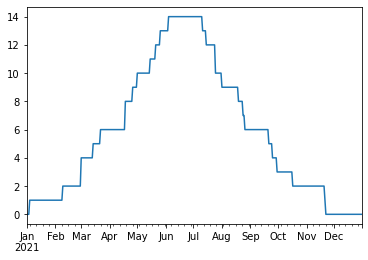

In [169]:
# the indexes for the period 1st Feb and 21st March (included) are 258 and 774

point = 2

dates = pd.date_range(start='01-01-2021', end='31-12-2021 23:59:00', freq='H')
result_timed = pd.DataFrame(index=range(8760), columns=['date','res','bin'], dtype='object')
result_timed['date'] = list(dates)
result_timed.loc[hoys,'res'] = result.iloc[point,:-1].values
result_timed['bin'] = 1

result_timed.index = dates

result_timed.loc[:,'bin'] = result_timed.loc[:,'bin'].where(result_timed['res']>0,other=0)

result_day = result_timed['bin'].resample('D').sum()
result_day.plot()

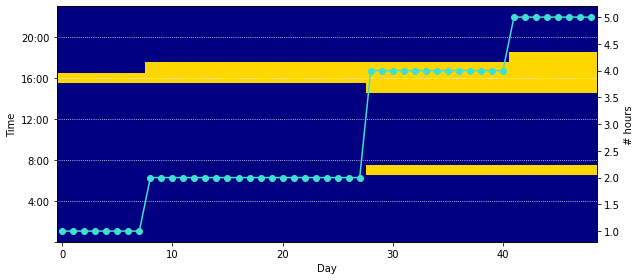

In [272]:
fig, ax1 = plt.subplots(figsize=(9,4))

cmap = colors.ListedColormap(['navy', 'gold'])
bounds=[0,.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

xlabel = [str(i).split()[0] for i in result_day['2021-02-01':'2021-03-21'].index]

ax1.imshow(result_timed['2021-02-01':'2021-03-21']['bin'].values.reshape(49,24).T, 
           aspect='auto', origin='lower', cmap=cmap, norm=norm)
ax1.set_ylabel('Time')
ax1.set_xlabel('Day')
ax1.set_yticks(range(0,24,4))
ax1.set_yticklabels(['','4:00','8:00','12:00','16:00','20:00'])
# ax1.set_xticks(range(49))
# ax1.set_xticklabels(xlabel, rotation=90, fontsize=8)
ax1.grid(axis='y', color='w', ls=':')
ax1.set_ylim(0,23)

ax2 = ax1.twinx()

ax2.plot(result_day['2021-02-01':'2021-03-21'].values, marker='o', color='turquoise')
ax2.set_ylabel('# hours')

fig.tight_layout()
plt.show()